## 安装 scikit-learn

命令：pip/pip3 install -U scikit-learn

## digits数据集
[数据集介绍](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html)

In [1]:
from sklearn.datasets import load_digits

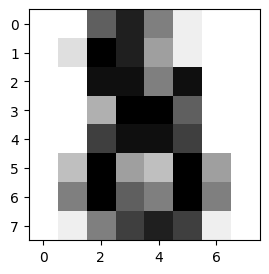

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load the digits dataset
digits = load_digits()

# Display the last digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()  # 读取数据

digits_X = digits.data  # 特征值
digits_y = digits.target  # 标签值

digits_X.shape, digits_y.shape

((1797, 64), (1797,))

## 数据预处理

首先，我们需要将目标值处理成独热编码的形式。

In [4]:
import numpy as np

digits_y = np.eye(10)[digits_y.reshape(-1)]
digits_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    digits_X, digits_y, test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437, 10), (360, 10))

## 定义模型类

In [6]:
import tensorflow as tf

class Model(object):
    def __init__(self):
        # 随机初始化张量参数
        self.W1 = tf.Variable(tf.random.normal([64, 30]))
        self.b1 = tf.Variable(tf.random.normal([30]))
        self.W2 = tf.Variable(tf.random.normal([30, 10]))
        self.b2 = tf.Variable(tf.random.normal([10]))

    def __call__(self, x):
        x = tf.cast(x, tf.float32)  # 转换输入数据类型
        # 线性计算 + RELU 激活
        fc1 = tf.nn.relu(tf.add(tf.matmul(x, self.W1), self.b1))  # 全连接层 1
        fc2 = tf.add(tf.matmul(fc1, self.W2), self.b2)  # 全连接层 2
        return fc2

/Users/yilonghao/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 定义损失函数

完成前向传播模型构建后，下一个步骤是定义损失函数。这里，我们选择深度神经网络构建过程中十分常用的一个损失函数：交叉熵损失函数。交叉熵损失函数本质上就是我们前面学过的对数损失函数。交叉熵主要用于度量两个概率分布间的差异性信息。
$$
H_{y}^{'}(y) =  = -\sum_{i} y_{i}^{'} log(y_{i})
$$

TensorFlow 中给出了交叉熵损失函数 + Softmax 函数二合一 API：tf.nn.softmax_cross_entropy_with_logits 。下面我们就可以直接使用该函数，其中 logits 是模型输出，labels 为样本的真实值。该 API 会返回每个样本的损失计算结果，所以我们会使用 tf.reduce_mean 求得平均值，从而得到在训练集上的损失。

In [7]:
def loss_fn(model, x, y):
    preds = model(x)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=y))

## 模型训练
有了损失函数，接下来就是定义优化器求得全局损失的最小值了。这里我们不再使用梯度下降，而是深度学习中更为常用的 Adam 优化器。Adam 实际上就是一种数学优化方法，Adam 的全称为 Adaptive Moment Estimation，它是一种自适应学习率的算法，其针对每一个参数都计算自适应的学习率。

In [8]:
EPOCHS = 200  # 迭代此时
LEARNING_RATE = 0.02  # 学习率
model = Model()  # 实例化模型类
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:  # 追踪梯度
        loss = loss_fn(model, X_train, y_train)

    trainable_variables = [model.W1, model.b1, model.W2, model.b2]  # 需优化参数列表
    grads = tape.gradient(loss, trainable_variables)  # 计算梯度

    optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adam 优化器
    optimizer.apply_gradients(zip(grads, trainable_variables))  # 更新梯度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f'Epoch [000/{EPOCHS}], Loss: [{loss:.4f}]')
    elif (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: [{loss:.4f}]')

Epoch [000/200], Loss: [239.8277]


Epoch [100/200], Loss: [5.1237]


Epoch [200/200], Loss: [2.1637]


## 模型评估

In [9]:
def accuracy_fn(logits, labels):
    preds = tf.argmax(logits, axis=1)  # 取值最大的索引，正好对应字符标签
    labels = tf.argmax(labels, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))

In [10]:
EPOCHS = 500  # 迭代此时
LEARNING_RATE = 0.02  # 学习率
model = Model()  # 实例化模型类
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:  # 追踪梯度
        loss = loss_fn(model, X_train, y_train)

    trainable_variables = [model.W1, model.b1, model.W2, model.b2]  # 需优化参数列表
    grads = tape.gradient(loss, trainable_variables)  # 计算梯度

    optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adam 优化器
    optimizer.apply_gradients(zip(grads, trainable_variables))  # 更新梯度

    accuracy = accuracy_fn(model(X_test), y_test)  # 计算准确度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f'Epoch [000/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]')
    elif (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]')

Epoch [000/500], Accuracy: [0.15], Loss: [294.1489]


Epoch [100/500], Accuracy: [0.82], Loss: [5.3633]


Epoch [200/500], Accuracy: [0.87], Loss: [3.2444]


Epoch [300/500], Accuracy: [0.84], Loss: [2.0531]


Epoch [400/500], Accuracy: [0.86], Loss: [1.6617]


Epoch [500/500], Accuracy: [0.86], Loss: [1.3992]
